In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=320000#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

In [3]:
root = r'D:\Users\Arkady\Verint\Coursera_2019_Tensorflow_Specialization\Course3_NLP'

In [4]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
#    -O /tmp/training_cleaned.csv

num_sentences = 0
corpus = []
with open(root + "/tmp/training_cleaned.csv", encoding='utf8', errors='ignore') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        list_item.append(row[5])
        label = 0
        if row[0] != '0':
          label = 1
        list_item.append(label)
        num_sentences = num_sentences + 1
        corpus.append(list_item)




In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[training_size-split:]
training_sequences = padded[0:training_size-split]
test_labels = labels[training_size-split:]
training_labels = labels[0:training_size-split]

In [7]:
training_labels_array = np.array(training_labels)
test_labels_array = np.array(test_labels)

In [8]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

227157
1


In [9]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open(root + '/tmp/glove.6B.100d.txt', encoding='utf8', errors='ignore') as f:
    for index, line in enumerate(f):
        values = line.split();
        word = values[0];
        try:
            coefs = np.asarray(values[1:], dtype='float32');
        except ValueError:
            print('error at line:', index, values)
            break
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [10]:
print(len(embeddings_matrix))
# Expected Output
# 138859

227158


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.Conv1D(embedding_dim, 5, activation='relu'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           22715800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 22,767,077
Trainable params: 51,277
Non-trainable params: 22,715,800
_____________________________________

In [13]:
num_epochs = 20
history = model.fit(training_sequences, training_labels_array, epochs=num_epochs, validation_data=(test_sequences, test_labels_array), verbose=2)

print("Training Complete")


Train on 288000 samples, validate on 32000 samples
Epoch 1/20
288000/288000 - 550s - loss: 0.5411 - accuracy: 0.7218 - val_loss: 0.5129 - val_accuracy: 0.7441
Epoch 2/20
288000/288000 - 536s - loss: 0.4939 - accuracy: 0.7571 - val_loss: 0.4959 - val_accuracy: 0.7573
Epoch 3/20
288000/288000 - 545s - loss: 0.4756 - accuracy: 0.7693 - val_loss: 0.4868 - val_accuracy: 0.7620
Epoch 4/20


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

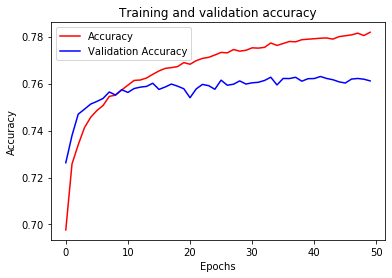

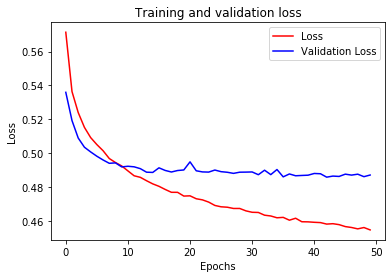

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!